# TEM Dataset Generation

The goal of this notebook is to:

- Showcase the simulation of target cryoEM datasets of choice
- Utilize the TEM wrapper and associated functions to do so

Workflow:

1) Configure and define inputs in `.yaml` files

2) Initialize TEM simulator with configuration files

3) Generate required simulator files.

4) Run simulator.

5) Parse and slice particle stacks. 

6) Generate metadata and sliced particle stack files.

## Pre-requisites
- Installation of TEM-simulator 1.3  (installation documentation found here: https://tem-simulator.sourceforge.net)
- Installation of ioSPI and simSPI and are on the same level
- Relevant libraries (conda activate recommended, alternatively see requirements.txt)

## TEM-Simulator

TEM-simulator is an open source program designed to simulate and produce transmission electron microscope images for the purpose of testing and evaluating reconstruction methods. These datasets are reproducible using generated metadata. Originally written in C, compSPI wraps it in an easily accessible Python package for usage in tandem with your reconstruction method of choice.

#### 1. Change working directory to match compSPI structure
Only run the cell below once upon kernel restart.

In [1]:
import os

root = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(root)
print("This is the root: " + root)

This is the root: /Users/callumhepworth/Developer/ENPH-459/compSPI


#### 2. Import requisite packages

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from simSPI import tem
from ioSPI import particle_metadata

/Users/callumhepworth/anaconda3/envs/simSPI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 3. Inputs 
To generate images the user is required to define a pair of `.yaml` files. These files define important fields such as characteristic dataset features or path configurations to save certain output files.

- `path_config.yaml`
    - `pdb_file` : path to the `.pdb` file for the structure the user wishes to generate.
    - `mrc_keyword` : appended descriptor to generated file names
    - `metadata_params_file` : file containing metadata .star file mappings
    - `output_dir` : path to output directory where metadata files are outputted.
    - `local_sim_dir` : path to local installation of TEM simulator

- `sim_config.yaml`
    - `molecular_model`
        - `voxel_size_nm` - [nm]
        - `particle_name` - name of the particle
        - `particle_mrcout` - volume map of sample is written

    - `specimen_grid_params`
        - `hole_diameter_nm` - [nm]
        - `hole_thickness_center_nm` - [nm]
        - `hole_thickness_edge_nm` - [nm]

    - `beam_parameters`
        - `voltage_kv:` - [kV]
        - `energy_spread_v` - [V]
        - `electron_dose_e_per_nm2` - [e/nm**2] dose per image
        - `electron_dose_std_e_per_nm2` - standard deviation of dose per image

    - `optics_parameters`
        - `magnification` 
        - `spherical_aberration_mm` - [mm]
        - `chromatic_aberration_mm` - [mm]
        - `aperture_diameter_um` - [um] in back focal plane
        - `focal_length_mm` - [mm]
        - `aperture_angle_mrad` - [mrad] of the condenser lens
        - `defocus_um` - [um]
        - `defocus_syst_error_um` - [um]
        - `defocus_nonsyst_error_um` - [um]
        - `optics_defocusout` - file to write defocus values

    - `detector_parameters`
        - `detector_nx_px` - number of pixels along X axis
        - `detector_ny_px` - number of pixels along Y axis
        - `detector_pixel_size_um` - [um]
        - `average_gain_count_per_electron` - average number of counts per electron
        - `noise` - [bool] whether quantized electron waves result in noise
        - `detector_q_efficiency` - detector quantum efficiency $0 < e < 1$
        - `mtf_params` - `[0,0,1,0,0]` is perfect detector.

    - `noise_parameters`
        - `signal_to_noise` - signal-to-noise-ratio for added white noise $0 < r < 1$
    
    - `miscellaneous`
        - `seed` - seed for simulator.    
  
Now we can define our `.yaml` paths.

In [3]:
path_config = "simSPI/path_config.yaml"
sim_config = "simSPI/sim_config.yaml"

#### 4. Define and run simulator

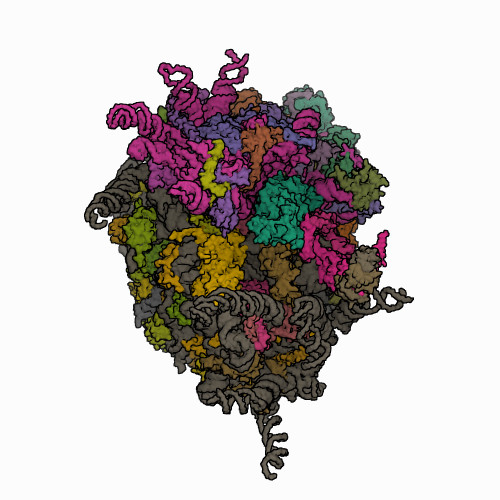

Structure of an example PDB file (4V6X), the human 80S ribosome.

In [4]:
simulator = tem.TEMSimulator(path_config, sim_config)

Once the simulator is initialized, the required simulator files are generated. These are parsed from the configuration files passed above, and contain the parameters the simulator requires to run.

In [5]:
simulator.generate_simulator_inputs()

/Users/callumhepworth/anaconda3/envs/simSPI/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


Once the simulator inputs are generated, the simulator wrapper can be called and the simulator ran as follows. The simulator is passed the internally parsed path and simulation config parameters and generates a number of files on completion. These include a .mrc file, contiaining the simulated micrgraph data, and a .log file, containing a status report of the simulation execution.

In [6]:
simulator.run_simulator()

After the simulated datasets are generated, the micrograph data and particle stacks can be parsed and extracted from the .mrc file. Doing so is done as follows.

In [7]:
micrograph_data, particle_stack = simulator.parse_simulator_data()

/Users/callumhepworth/anaconda3/envs/simSPI/lib/python3.9/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x44 0x11 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


This is the resultant data from the simulation, and can be viewed below. 

In [8]:
def view_particles(data, slicing=(1, 1, 1), figsize=1, ncol=5):
    """
    Helper function to display slices.
    """
    view = data[:: slicing[0], :: slicing[1], :: slicing[2]]
    figsize = int(figsize * ncol)
    nrow = np.ceil(view.shape[0] / ncol)
    fig = plt.figure(figsize=(ncol * figsize, nrow * figsize))

    for i in np.arange(view.shape[0]):
        fig.add_subplot(int(nrow), int(ncol), i + 1)
        plt.imshow(view[i], cmap="Greys")

    plt.tight_layout()
    plt.show()

#### 5. View results

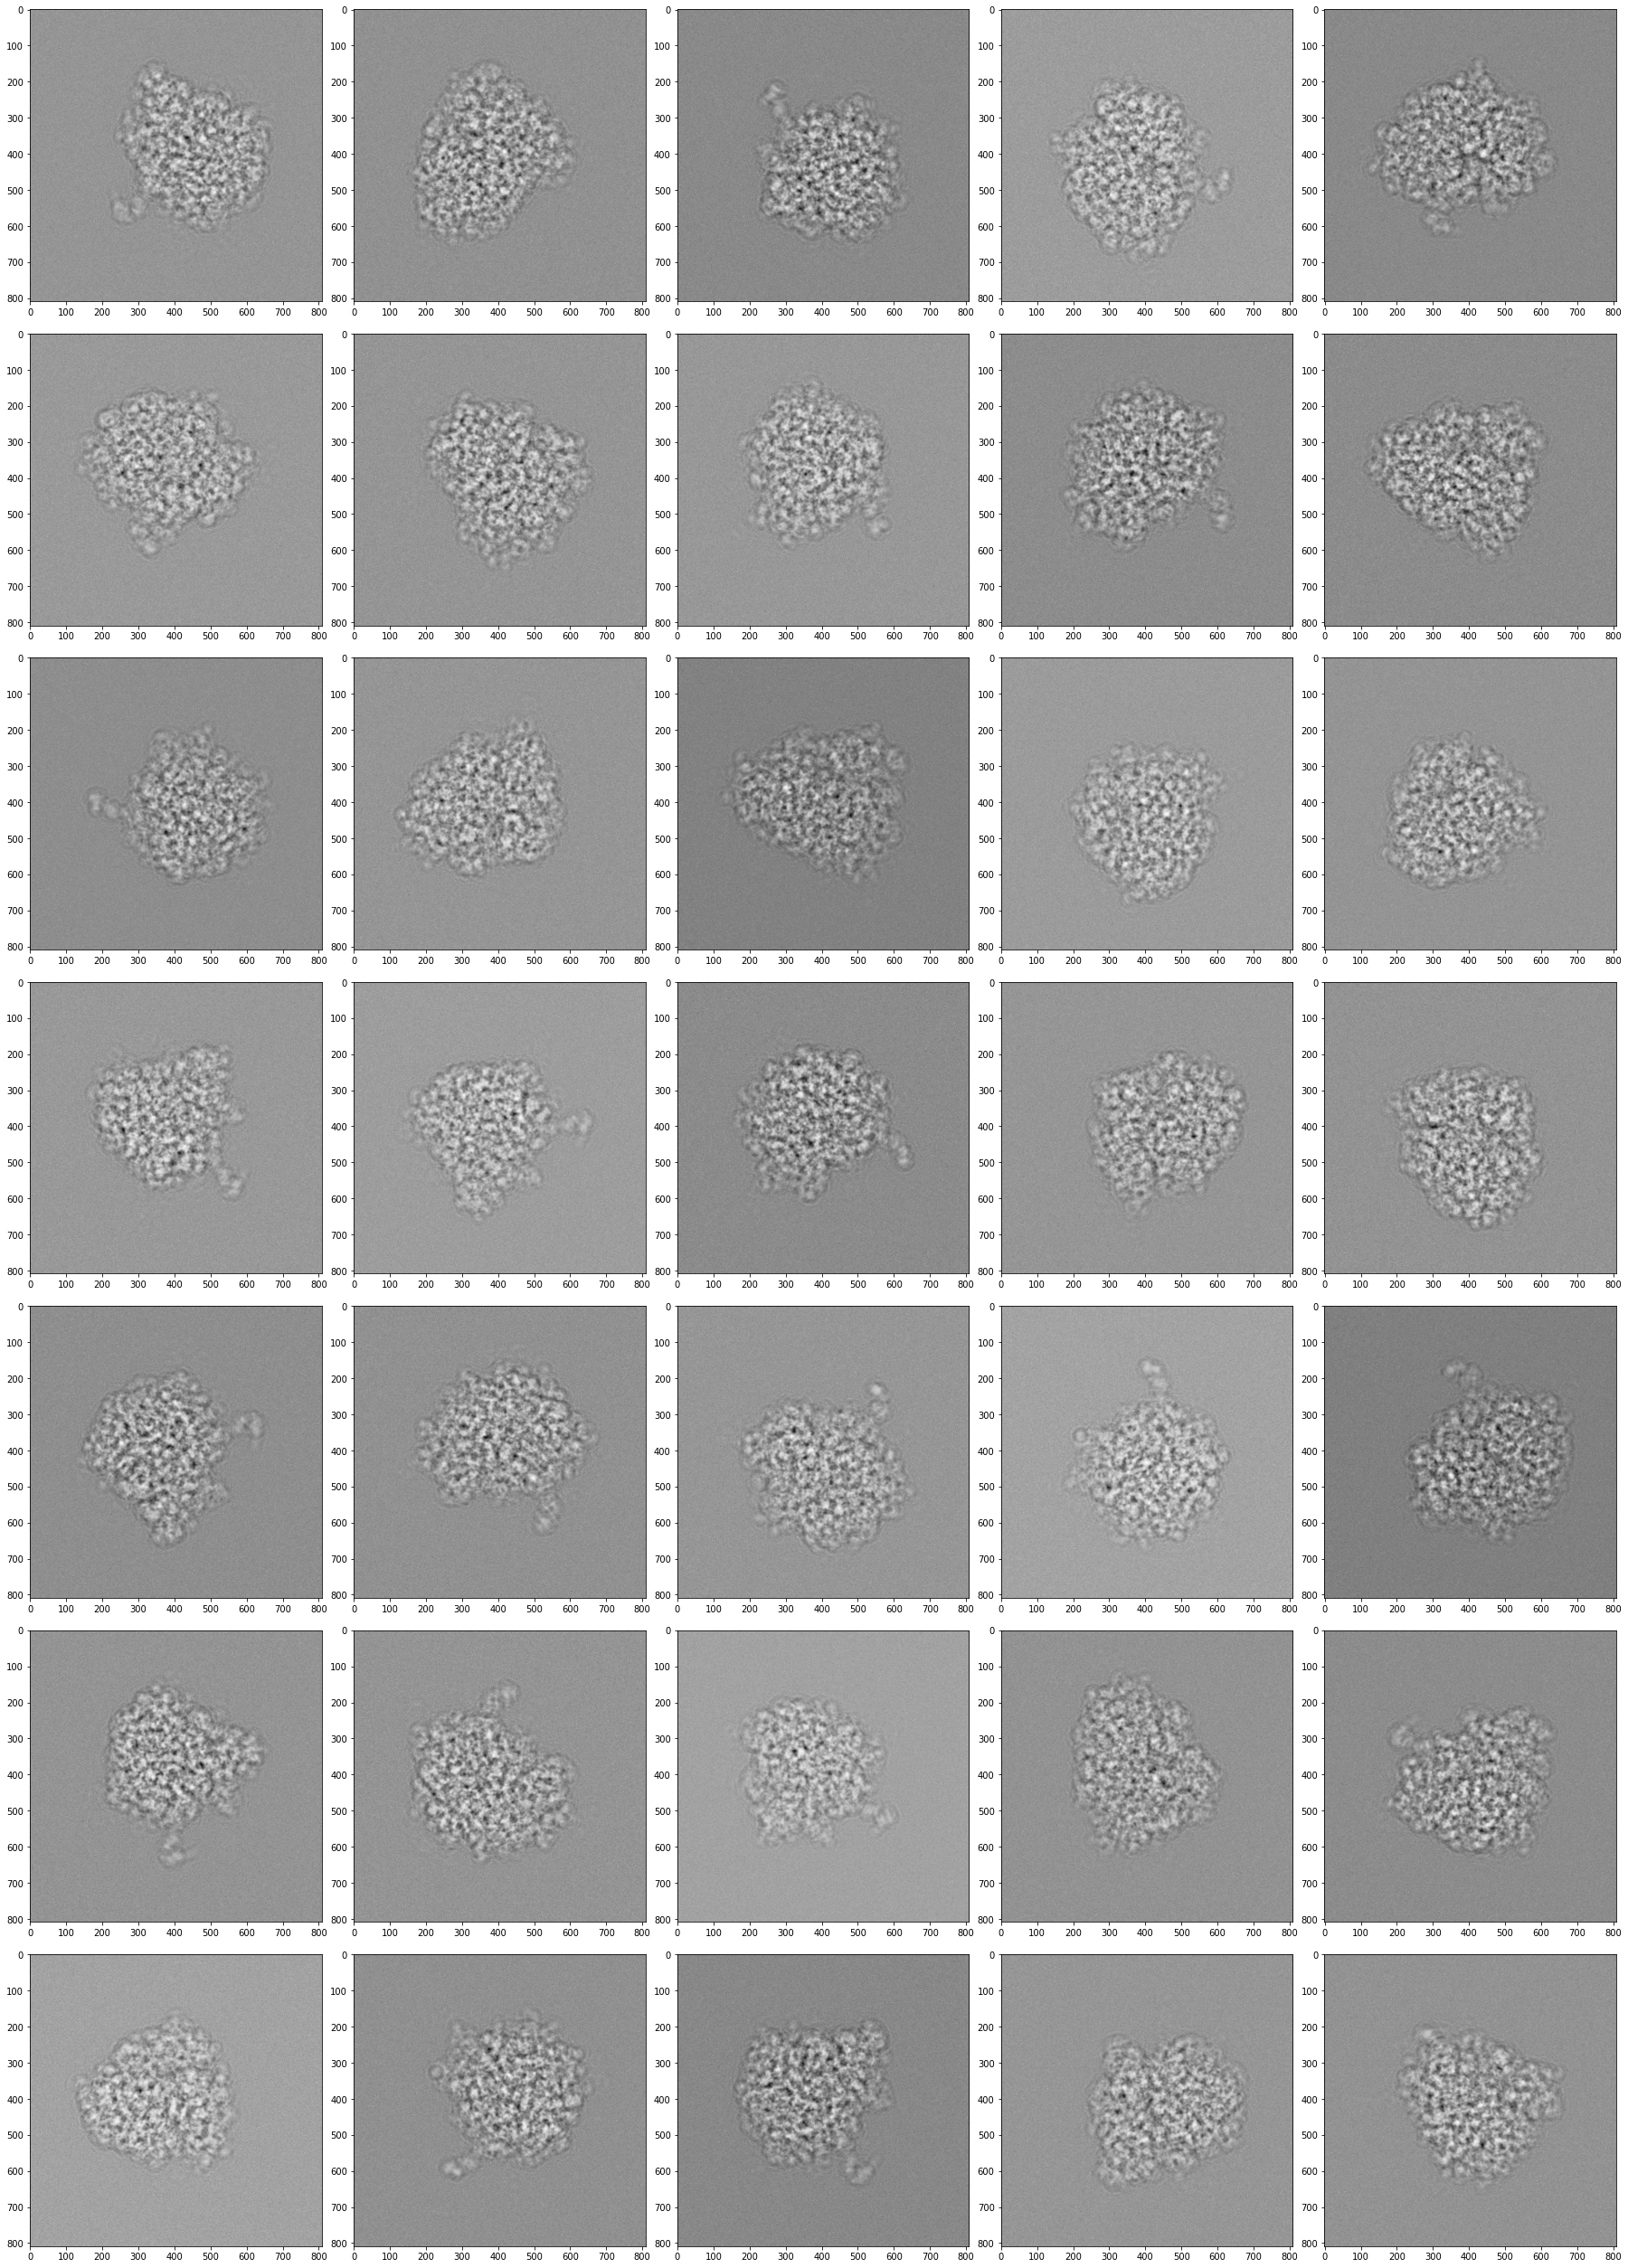

In [9]:
view_particles(particle_stack[0])

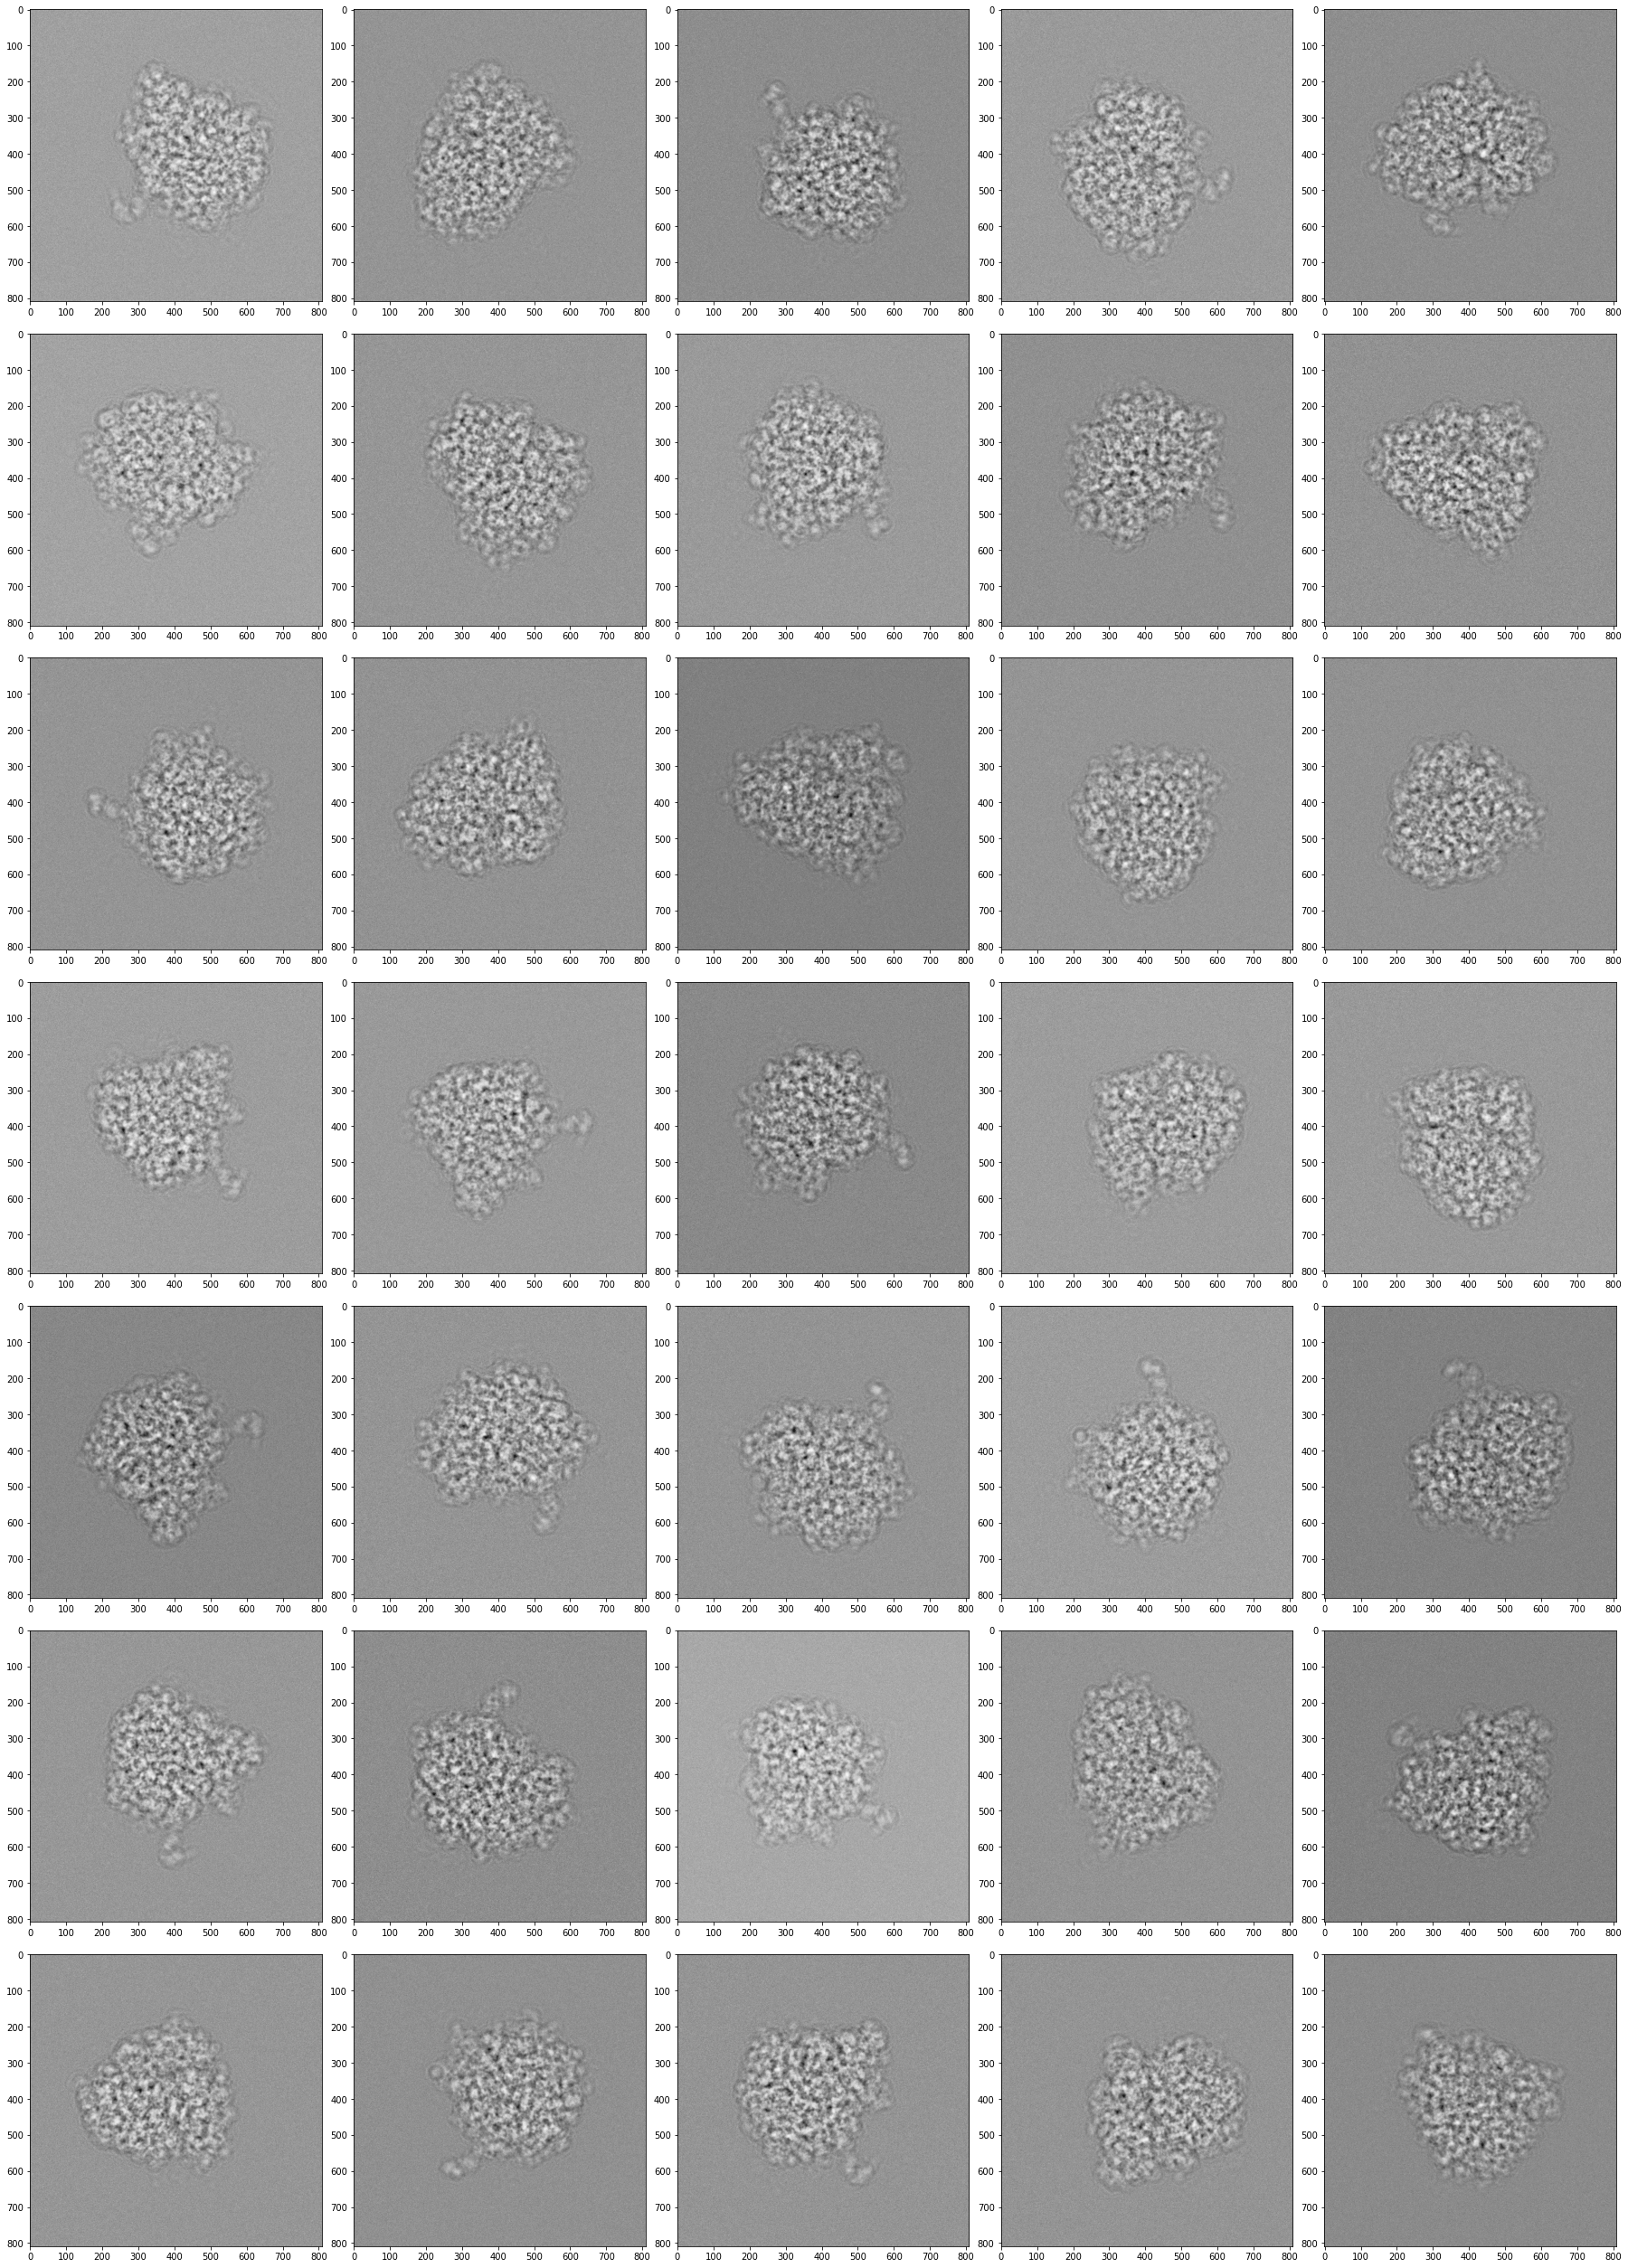

In [10]:
view_particles(particle_stack[1])

In [11]:
simulator.export_simulated_data(particle_stack)

('simSPI/temp_workspace/output/4v6x_randomrot.h5',
 'simSPI/temp_workspace/output/4v6x_randomrot.star')

### Outputs
See output directory as you defined in `path_config.yaml`.
- `.h5` file : Creation of 2D particle stack from input .pdb structure
- `.star` file : Metadata associated with generated stack for reproduction
    - Specifies detector input parameters as defined by user in configuration `.yaml`'s
    - Generated parameters seeded by user inputs

### Upload

In [12]:
def upload_dataset_from_files(
    token: str, data_file: str, metadata_file: str, data_node_guid: str = "24htr"
) -> bool:
    """Upload particle stack data and metadata as labelled datasets to OSF.io.
    Parameters
    ----------
    data_file : str
        File path to .h5 file containing datasets.
    metadata_file : str
        File path to .star file containing relevant meta data.
    Returns
    -------
    bool
        True if all uploads successful, False otherwise.
    """

    osf = datasets.OSFUpload(token, data_node_guid)

    with open(metadata_file, "r") as file:
        parsed_metadata = ReadCif(file, grammar="STAR2")

    structure_name = Path(parsed_metadata["particle"]["_pdb_file"]).stem
    dataset_name = Path(parsed_metadata["simulation"]["_log_file"]).stem

    structure_guid = osf.read_structure_guid(structure_name)

    if not structure_guid:
        structure_guid = osf.write_child_node(osf.data_node_guid, structure_name)

    # get tags
    tags = []

    dataset_guid = osf.write_child_node(structure_guid, dataset_name, tags)

    upload_file_paths = [data_file, metadata_file]
    return osf.write_files(dataset_guid, upload_file_paths)